<a href="https://colab.research.google.com/github/reachsidd/fina_project_6740/blob/main/python/FinalProject3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
import re
import string

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import nltk
import sklearn.model_selection
nltk.download('punkt')
nltk.download('stopwords')
import bs4
import wordcloud

import keras.preprocessing
import tensorflow as tf
import zipfile
import sklearn.pipeline
import sklearn.model_selection
import pprint

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
# get raw text from htmls
def clean_html(text):
    soup = bs4.BeautifulSoup(text, 'html.parser')
    return soup.get_text()

In [11]:
# remove stopwords, punctuations and lower the case
def remove_stopwords_case_normalization(text):
    stopwords = nltk.corpus.stopwords.words('english')
    #print(stopwords)
    text_new = text.lower()
    text_new = re.sub('[^a-z]', ' ', text_new)
    # print(text_new)
    text_new = "".join([i for i in text_new if i not in string.punctuation])
    #print(text_new)
    words = text_new.split()
    #print(words)
    text_new = " ".join([i for i in words if i not in stopwords])
    #print(text_new)
    return text_new

In [12]:
def clean_text(text):
    # Remove urls
    text_new = re.sub(r'http\S+', '', text)
    text_new = clean_html(text_new)
    text_new = remove_stopwords_case_normalization(text_new)
    return text_new

In [8]:
fake_github_url='https://github.com/reachsidd/fina_project_6740/blob/main/data/Fake.zip?raw=true'
true_github_url='https://github.com/reachsidd/fina_project_6740/blob/main/data/True.zip?raw=true'

fake_data_original = pd.read_csv(fake_github_url,compression='zip')
true_data_original = pd.read_csv(true_github_url,compression='zip')

# null check
print(fake_data_original.isna().sum())
# null check
print(true_data_original.isna().sum())


true_data_original.head()

title      0
text       0
subject    0
date       0
dtype: int64
title      0
text       0
subject    0
date       0
dtype: int64


,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [18]:
fake_data = fake_data_original.copy()
true_data = true_data_original.copy()

fake_data['content'] = fake_data['title'] + ' ' + fake_data['text']
fake_data['label'] = 0
fake_data.drop(columns=['title', 'text', 'subject', 'date'], inplace=True)
print(fake_data.head())

true_data['content'] = true_data['title'] + ' ' + true_data['text']
true_data['label'] = 1
true_data.drop(columns=['title', 'text', 'subject', 'date'], inplace=True)
print(true_data.head())

fake_data['content'] = fake_data['content'].apply(clean_text)
print(fake_data.head())

true_data['content'] = true_data['content'].apply(clean_text)
print(true_data.head())



#FOR TESTING ONLY
#train = train.head(100)
#test = test.head(100)

                                             content  label
0   Donald Trump Sends Out Embarrassing New Year’...      0
1   Drunk Bragging Trump Staffer Started Russian ...      0
2   Sheriff David Clarke Becomes An Internet Joke...      0
3   Trump Is So Obsessed He Even Has Obama’s Name...      0
4   Pope Francis Just Called Out Donald Trump Dur...      0
                                             content  label
0  As U.S. budget fight looms, Republicans flip t...      1
1  U.S. military to accept transgender recruits o...      1
2  Senior U.S. Republican senator: 'Let Mr. Muell...      1
3  FBI Russia probe helped by Australian diplomat...      1
4  Trump wants Postal Service to charge 'much mor...      1
                                             content  label
0  donald trump sends embarrassing new year eve m...      0
1  drunk bragging trump staffer started russian c...      0
2  sheriff david clarke becomes internet joke thr...      0
3  trump obsessed even obama name coded 

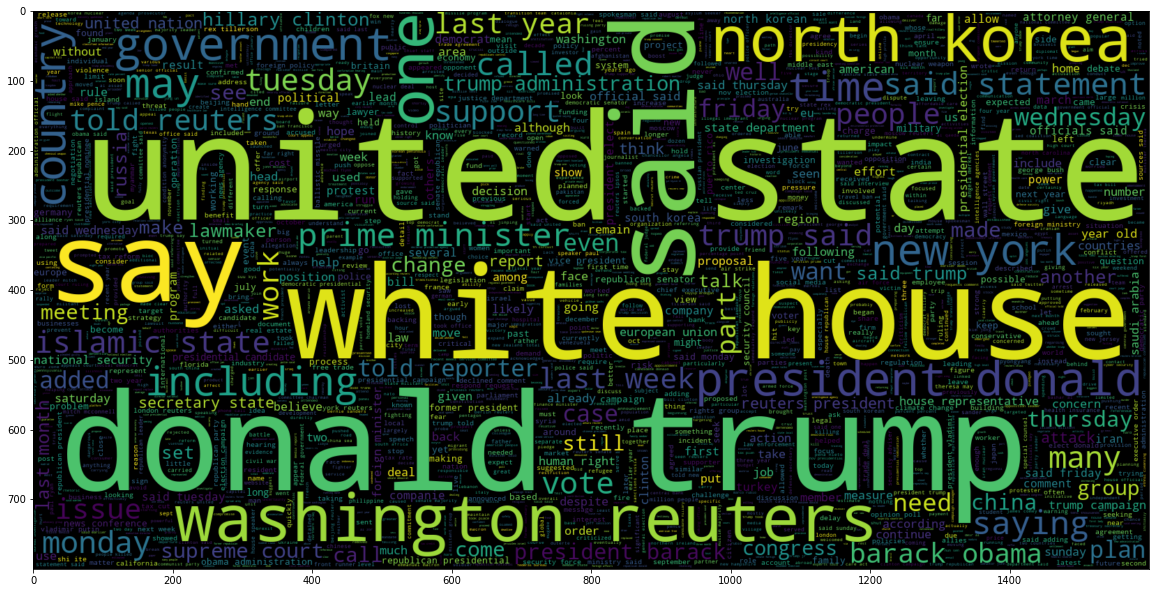

In [15]:
# WORDCLOUD FOR  CLEAN TEXT(LABEL - 1 - True)
plt.figure(figsize=(20, 20))  # Text that is not Fake
wc = wordcloud.WordCloud(max_words=2000, width=1600, height=800, stopwords=wordcloud.STOPWORDS).generate(" ".join(true_data.content))
plt.imshow(wc, interpolation='bilinear')
plt.show()

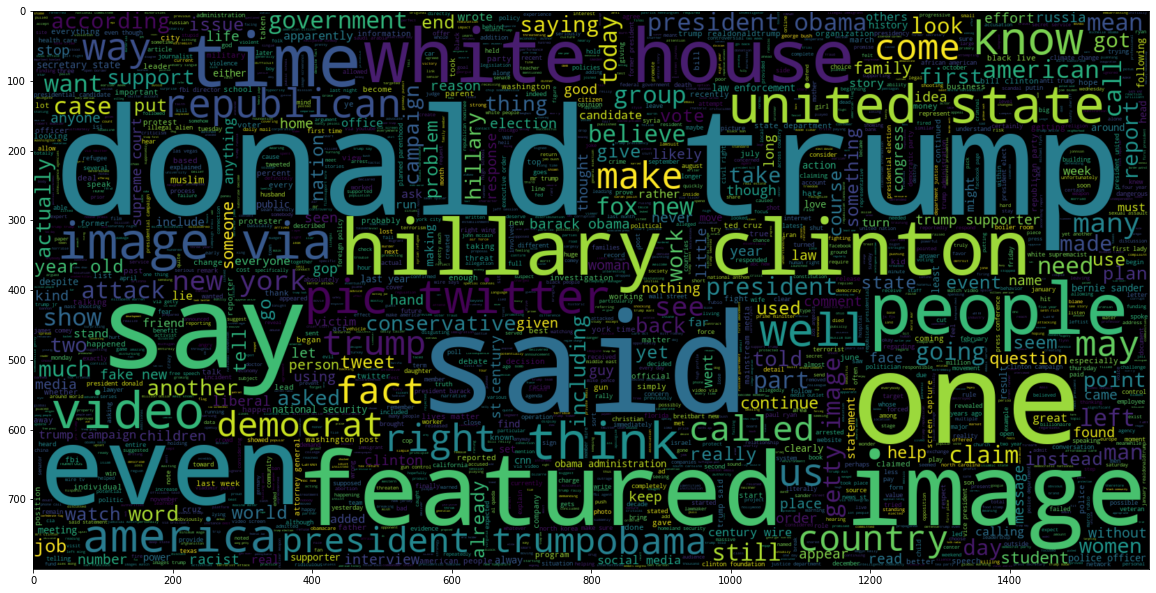

In [17]:
# WORDCLOUD FOR  FAKE TEXT(LABEL - 0 - fake)
plt.figure(figsize=(20, 20))  # Text that is Fake
wc = wordcloud.WordCloud(max_words=2000, width=1600, height=800, stopwords=wordcloud.STOPWORDS).generate(" ".join(fake_data.content))
plt.imshow(wc, interpolation='bilinear')
plt.show()

In [19]:
# NLP - Tokenize and apply Porter’s Stemmer algorithm
ps = nltk.stem.porter.PorterStemmer()

fake_data['content'] = fake_data['content'].apply(lambda x:' '.join([ps.stem(word) for word in nltk.tokenize.word_tokenize(x)]))
print(fake_data.head())

true_data['content'] = true_data['content'].apply(lambda x:' '.join([ps.stem(word) for word in nltk.tokenize.word_tokenize(x)]))
print(true_data.head())



                                             content  label
0  donald trump send embarrass new year eve messa...      0
1  drunk brag trump staffer start russian collus ...      0
2  sheriff david clark becom internet joke threat...      0
3  trump obsess even obama name code websit imag ...      0
4  pope franci call donald trump christma speech ...      0
                                             content  label
0  u budget fight loom republican flip fiscal scr...      1
1  u militari accept transgend recruit monday pen...      1
2  senior u republican senat let mr mueller job w...      1
3  fbi russia probe help australian diplomat tip ...      1
4  trump want postal servic charg much amazon shi...      1


In [20]:
fake_X_train, fake_X_test, fake_y_train, fake_y_test = sklearn.model_selection.train_test_split(fake_data['content'], fake_data['label'], test_size=0.2, random_state=42)
true_X_train, true_X_test, true_y_train, true_y_test = sklearn.model_selection.train_test_split(true_data['content'], true_data['label'], test_size=0.2, random_state=42)

X_train = np.concatenate((fake_X_train, true_X_train), axis=0)
X_test = np.concatenate((fake_X_test, true_X_test), axis=0)
y_train = np.concatenate((fake_y_train, true_y_train), axis=0)
y_test = np.concatenate((fake_y_test, true_y_test), axis=0)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(35917,)
(8981,)
(35917,)
(8981,)


**1.   using TFIDF and PassiveAggresive cassifier**




In [35]:
pipeline = sklearn.pipeline.Pipeline([
                                      ('tfidfvect', sklearn.feature_extraction.text.TfidfVectorizer()),
                                      ('clfmodel', sklearn.linear_model.PassiveAggressiveClassifier()),
                                      ])

parameters = [{
    'tfidfvect__max_df': [0.25,0.5, 0.75, 1.0],
    'clfmodel__max_iter':[10000],
    'clfmodel__random_state':[999], 
    'clfmodel__tol':[1e-3],
}]

grid_search = sklearn.model_selection.GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)

print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
pprint.pprint(parameters)
grid_search.fit(X_train, y_train)
print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()


Performing grid search...
pipeline: ['tfidfvect', 'clfmodel']
parameters:
[{'clfmodel__max_iter': [10000],
  'clfmodel__random_state': [999],
  'clfmodel__tol': [0.001],
  'tfidfvect__max_df': [0.25, 0.5, 0.75, 1.0]}]
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.2min finished


Best score: 0.993
Best parameters set:


TypeError: ignored

In [50]:
#print(best_parameters)
kwargs ={}
for dict1 in parameters:
  for key in dict1:
    print(key, best_parameters[key])
    kwargs[key]= best_parameters[key]

print(kwargs)
pipeline.set_params(**kwargs)

pipeline.fit(X_train, y_train)
print('pipeline.score=',pipeline.score(X_test,y_test))
y_test_pred = pipeline.predict(X_test)
print(y_test_pred)
accuracy = sklearn.metrics.accuracy_score(y_test, y_test_pred)
precision, recall, fbeta_score,_ = sklearn.metrics.precision_recall_fscore_support(y_test, y_test_pred,average='micro')

print(accuracy, precision, recall, fbeta_score)


tfidfvect__max_df 0.5
clfmodel__max_iter 10000
clfmodel__random_state 999
clfmodel__tol 0.001
{'tfidfvect__max_df': 0.5, 'clfmodel__max_iter': 10000, 'clfmodel__random_state': 999, 'clfmodel__tol': 0.001}
pipeline.score= 0.9957688453401625
[0 0 0 ... 1 1 1]
0.9957688453401625 0.9957688453401625 0.9957688453401625 0.9957688453401625


In [ ]:
tfid_vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.3)
# returns X sparse matrix of (n_samples, n_features)
x_train = tfid_vectorizer.fit_transform(train['content'].values)
x_test = tfid_vectorizer.transform(test['content'].values)
print(x_train.shape)
print(x_test.shape)
y_train = train['label']
y_test = test['label']
print(y_train.shape)
print(y_test.shape)

(20800, 109680)
(5200, 109680)
(20800,)
(5200,)


In [ ]:
#Creating and training  model
model = sklearn.linear_model.PassiveAggressiveClassifier(max_iter=10000, random_state=999, tol=1e-3).fit(x_train,y_train)

In [ ]:

train_accuracy=model.score(x_train, y_train)
test_accuracy=model.score(x_test, y_test)

print('train_accuracy=',train_accuracy)
print('test_accuracy=',test_accuracy)



train_accuracy= 1.0
test_accuracy= 0.635576923076923
